## The Markowitz Portfolio Allocation Problem: Risky and Risk-Free Assets
[Markowitz portfolio allocation](https://en.wikipedia.org/wiki/Markowitz_model) identifies the weights $w$'s for assets in a portfolio such that the portfolio variance (risk) is minimized for a specified rate of portfolio return (reward). The Markowitz allocation problem for a portfolio $\mathcal{P}$ composed of both risky and risk-free assets (savings accounts, certificate of deposit, bonds, etc.) is given by:

\begin{eqnarray*}
\text{minimize}~\sigma_{\mathcal{P}}^2 &=& \sum_{i\in\mathcal{P}}\sum_{j\in\mathcal{P}}w_{i}w_{j}
\text{cov}\left(r_{i},r_{j}\right) \\
\text{subject to}~\mathbb{E}(r_{\mathcal{P}})& = & \left(w_{f}r_{f}+\sum_{i\in\mathcal{P}}w_{i}\cdot\mathbb{E}(r_{i})\right)\geq{R^{*}}\\
w_{f}+\sum_{i\in\mathcal{P}}w_{i} & = & 1\\
\text{and}~w_{i}&\geq&{0}\qquad{\forall{i}\in\mathcal{P}}
\end{eqnarray*}

The term $w_{i}\geq{0}$ denotes the fraction of risky asset $i$ in the portfolio $\mathcal{P}$, the quantity $w_{f}$ denotes the weight of risk-free assets in the portfolio $\mathcal{P}$, $r_{f}$ denotes the risk free rate, while $R^{*}$ is the minimal required return for $\mathcal{P}$. The term $\sigma_{\mathcal{P}}$ denotes the portfolio variance, $r_{i}$ denotes the return for asset $i$ and $\text{cov}\left(r_{i},r_{j}\right)$ denotes [covariance](https://en.wikipedia.org/wiki/Covariance) between the return of asset $i$ and $j$ in the portfolio. The non-negativity of the fractions $w_{i}$ forbids short selling. This constraint can be relaxed if borrowing is allowed. 

### Learning objectives
In this example, we'll compute the [efficient frontier](https://en.wikipedia.org/wiki/Efficient_frontier) for a portfolio of risky assets, where the expected return and the covariance of the returns are calculated from a historical dataset. Then, we'll compute the optimal allocation for a portfolio with both risky and risk-free assets.

#### Tasks
* First, load the daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) over the last five years.
* Second, compute the expected returns and the covariance arrays from the historical dataset
* Next, compute the efficient frontier by solving the optimization problem described above: minimize the risk for a specified minimum reward value.
* Finally, using the covariance and return arrays, solve the allocation problem with a risk-free asset in addition to risky assets

## Setup
The computations in this lab (or example) are enabled by the [VLDecisionsPackage.jl](https://github.com/varnerlab/VLDecisionsPackage.jl.git) and several external `Julia` packages. To load the required packages and any custom codes the teaching team has developed to work with these packages, we [include](https://docs.julialang.org/en/v1/manual/code-loading/) the `Include.jl` file):

In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-5760-Labs-F23`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLDecisionsPackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-5760-Labs-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5760-Labs-F23/Manifest.toml`


### Types
The `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, which encodes data required to compute the efficient frontier for a collection of $N$ risky assets only, has the fields:
* `Σ::Array{Float64,2}` is the $N\times{N}$ covariance matrix
* `μ::Array{Float64,1}` is the $N\times{1}$ vector of expected return values
* `bounds::Array{Float64,2}` is an $N\times{1}$ array that holds the upper and lower bound for the asset allocation. Each row corresponds to an asset, while the first column is the lower bound, and the second column is the upper bound on the asset allocation fraction.
* `R::Float64` denotes the lower bound on the 
* `initial::Array{Float64,1}` is the $N\times{1}$ array of initial guesses

The `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem`, which encodes data required to compute the optimal allocation for a portfolio containing $N$ risky assets and a single risk-free asset, has the fields:
* `Σ::Array{Float64,2}` is the $N\times{N}$ covariance matrix
* `μ::Array{Float64,1}` is the $N\times{1}$ vector of expected return values
* `bounds::Array{Float64,2}` is an $N\times{1}$ array that holds the upper and lower bound for the asset allocation. Each row corresponds to an asset, while the first column is the lower bound, and the second column is the upper bound on the asset allocation fraction.
* `R::Float64` denotes the lower bound on the 
* `initial::Array{Float64,1}` is the $N\times{1}$ array of initial guesses
* `risk_free_rate::Float64` is the risk-free rate of return, e.g., the rate of return on a [10-year US Treasury Note](https://www.cnbc.com/bonds/)

### Methods
* The `MyPortfolioDataSet()` function loads the risky asset price dataset, and returns it as a [DataFrame.jl](https://dataframes.juliadata.org/stable/) instance. 
* The `build(...)` is a factory method that takes the type of object that you wish to construct, and the parameters required to construct the object, e.g., the fields of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` or `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem` types.
* The `solve(...)` method takes a `problem` type, e.g., an instance of `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem` and returns the solution to the problem as a [Julia Dictionary](https://docs.julialang.org/en/v1/base/collections/#Dictionaries) instance.

## Task 1: Load the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) for the past five-trading years (a maximum of `1256` data points per firm). However, not all the firms in the `dataset` have the maximum number of trading days, i.e., some firms are missing information for various reasons; perhaps they were acquired, merged, or delisted, etc. We will exclude these firms from the `dataset`.

We load the price `dataset` by calling the `MyPortfolioDataSet()` function:

In [2]:
dataset = MyPortfolioDataSet() |> x-> x["dataset"];

While it is sometimes convenient to work with the data using the `firm_index`, often we want to specify the [ticker symbol](https://en.wikipedia.org/wiki/Ticker_symbol#:~:text=A%20ticker%20symbol%20or%20stock,on%20a%20particular%20stock%20market.) instead. To facilitate this, let's load a mapping between the `firm_index` and the ticker symbols using the `MyFirmMappingDataSet()` function:

In [3]:
firm_mapping = MyFirmMappingDataSet()

Row,Symbol,Name,Sector
,String7,String,String31
1,MMM,3M,Industrials
2,AOS,A. O. Smith,Industrials
3,ABT,Abbott Laboratories,Health Care
4,ABBV,AbbVie,Health Care
5,ABMD,Abiomed,Health Care
6,ACN,Accenture,Information Technology
7,ATVI,Activision Blizzard,Communication Services
8,ADM,ADM,Consumer Staples
9,ADBE,Adobe,Information Technology


In [4]:
ticker_lookup_dictionary = Dict{String,Int64}();
number_of_map_elements = nrow(firm_mapping);
for i ∈ 1:number_of_map_elements
    ticker = firm_mapping[i,:Symbol];
    ticker_lookup_dictionary[ticker] = i;
end

Each firm is assigned an `index` (the `keys` of the `dataset` dictionary). Let's specify a list of `tickers` and look up the corresponding `firm_index` using the `ticker_lookup_dictionary` dictionary. We'll hold the indexes of the firms we are interested in in the `firms` array:

In [5]:
tickers = ["AAPL", "WFC", "BAC", "GM", "F", "AMD", "INTC", "MU", "PFE", "PG"];
firms = Array{Int64,1}();
for ticker ∈ tickers
    firm_index = ticker_lookup_dictionary[ticker];
    push!(firms, firm_index)
end

Finally, we set some constant values that are used in the computation of the efficient frontier and the capital allocation line:

In [6]:
number_of_firms = length(firms);
initial = zeros(number_of_firms);
initial[1] = 1.0;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
r̄ = 0.045;
# risk_free_rate = ((1+r̄)^(1/252) - 1);
risk_free_rate = r̄
number_of_points = 20;

### Task 2: Compute the expected return and covariance matrices
First, we compute the expected (annualized) log return by passing the `dataset` and a list of firms we are interested in (held in the $N\times{1}$ `firms` array) to the `log_return_matrix(...)` method. The result is stored in the `return_matrix` variable, a $T-1\times{N}$ array of log return values. 
Each row of `return_matrix` corresponds to a time-value, while each column corresponds to a firm: 

In [7]:
return_matrix = log_return_matrix(dataset, firms);

Next, we estimate the `covariance_matrix` from the `return_matrix` using the `cov(...)` function which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/): 

In [8]:
covariance_matrix = cov(return_matrix);

Finally, we estimate the expected return for each firm from the `return_matrix` using the `mean(...)` function which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/): 

In [9]:
tmp = mean(return_matrix, dims=1);
expected_return = Array{Float64,1}()
for i ∈ 1:number_of_firms
    push!(expected_return, tmp[i])
end

### Task 3: Compute the efficient frontier (risky assets only)
First, let's create an instance of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, and store this in the `problem_risk` variable, using the `build(...)` method. We pass the covariance array estimated from data, and the expected return value, along with bounds and an initial guess to the `build(...)` method:

In [10]:
problem_risk = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = covariance_matrix,
    μ = expected_return,
    bounds = bounds,
    initial = initial,
    R = 0.0
));

Next, we create an array with the minimum desired rewards (the calculation must achieve at least this much reward). We store these values in the `minimum_desired_reward_array` variable:

In [11]:
minimum_desired_reward_array = range(risk_free_rate, stop = 10*risk_free_rate, length = number_of_points) |> collect;

Finally, we iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level using a `for-loop`. In particular, for each pass through the loop, we:
* Update the `problem_risk` variable with the minimum desired reward
* We then pass the updated `problem_risk` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store the solution in the `efficient_frontier` dictionary.

In [12]:
efficient_frontier = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk.R = minimum_desired_reward_array[i];
    
    # compute -
    solution = solve(problem_risk)

    # check: did this converge?
    status_flag = solution["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        key = sqrt(solution["objective_value"]);
        value = solution["reward"];
        efficient_frontier[key] = value;
    end
end

#### Visualize the efficient frontier

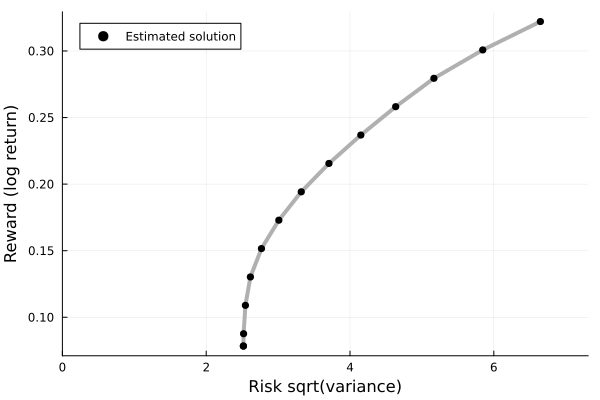

In [13]:
plot(efficient_frontier, lw=4, xlabel="Risk sqrt(variance)", 
    ylabel="Reward (log return)", fontsize=18, label="", c=:gray69, 
    xlim=(0.0, 1.1*maximum(efficient_frontier).first))
scatter!(efficient_frontier, label="Estimated solution", c=:black)

### Task 4: Optimal allocation with risky and risk-free assets
Finally, let's create an instance of the `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem` type, and store this in the `problem_risk_free` variable, using the `build(...)` method. We pass the covariance array estimated from data, and the expected return value, along with bounds, an initial guess and the risk free rate to the `build(...)` method:

In [14]:
problem_risk_free = build(MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem, (
    Σ = covariance_matrix,
    μ = expected_return,
    bounds = bounds,
    initial = initial,
    risk_free_rate = risk_free_rate,
    R = 0.0
));

Iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level, in the presence of a risk-free asset, using a `for-loop`. In particular, for each pass through the loop, we:
* Update the `problem_risk_free` variable with the minimum desired reward
* We then pass the updated `problem_risk_free` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution_risk_free` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store the solution in the `capital_allocation_line` dictionary.

In [15]:
capital_allocation_line = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk_free.R = minimum_desired_reward_array[i];
    
    # compute -
    solution_risk_free = solve(problem_risk_free)

    # check: did this converge?
    status_flag = solution_risk_free["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        key = sqrt(solution_risk_free["objective_value"]);
        value = solution_risk_free["reward"];
        capital_allocation_line[key] = value;
    end
end
capital_allocation_line;

#### Visualize the capital allocation line

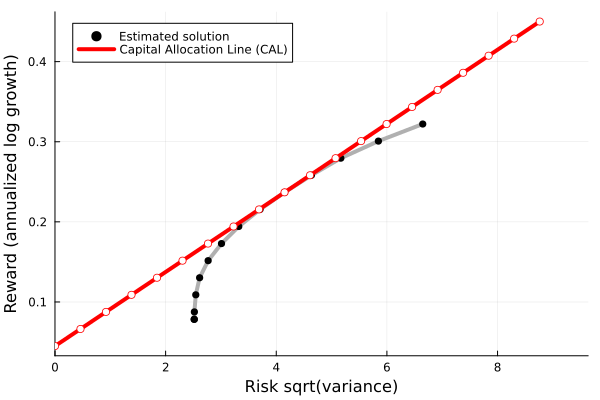

In [16]:
plot!(capital_allocation_line, lw=4, xlabel="Risk sqrt(variance)", 
    ylabel="Reward (annualized log growth)", fontsize=18, c=:red, 
    xlim=(0.0, 1.1*maximum(capital_allocation_line).first), label="Capital Allocation Line (CAL)")
scatter!(capital_allocation_line, label="", msc=:red, mc=:white)

### Analysis

In [17]:
problem_risk_free.R = 0.14;
solution_risk_free = solve(problem_risk_free)

Dict{String, Any} with 4 entries:
  "argmax"          => [0.242535, -9.99435e-9, -9.9901e-9, -9.99452e-9, -9.9934…
  "reward"          => 0.14
  "status"          => LOCALLY_SOLVED
  "objective_value" => 4.22336

In [18]:
w_opt = solution_risk_free["argmax"];
idx = findall(x-> abs(x)>0.005, w_opt)
[tickers[idx] w_opt[idx]]

3×2 Matrix{Any}:
 "AAPL"  0.242535
 "AMD"   0.158335
 "PG"    0.101321

In [19]:
wf = 1 - sum(w_opt) # fraction in cash
println("We have $(wf) in the risk-free asset in the portfolio")

We have 0.49780937497266053 in the risk-free asset in the portfolio


In [20]:
σ = 2.576*sqrt(solution_risk_free["objective_value"]);
mean_return = 100*(exp(problem_risk_free.R) - 1)
println("The return from this portfolio should be $(mean_return) ± $(σ) percent. This has a 100 x CV = $((σ/mean_return)*100) at a 99% CI");

The return from this portfolio should be 15.027379885722736 ± 5.293892070816308 percent. This has a 100 x CV = 35.228310664096185 at a 99% CI
